# Xarray + Cloud OISST (One-Month) Basics & Stats

This notebook demonstrates basic **xarray** operations on a **one-month** subset of a cloud-hosted climate dataset: **NOAA OISST v2.1 daily SST** on AWS Public Datasets (NetCDF files). You'll:
- Discover files for one month on S3 with `fsspec`
- Open them with `xarray.open_mfdataset` (anonymous S3)
- Inspect dataset structure
- Subset in space (and within that month)
- Compute basic stats (mean, std, anomalies relative to the month’s mean)
- Make maps of the month-mean and variability

**Deliverables:** Answer the **🧩 Questions** in the markdown prompts. Fill in the code where indicated by `# TODO`.


In [2]:
import xarray as xr
import fsspec
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['figure.dpi'] = 120


## 1) Open the cloud dataset (NetCDF on AWS, one month)

We'll access **NOAA OISST v2.1 (daily)** in the NOAA CDR bucket on AWS. Files are arranged by **YYYYMM**.

**🧩 Questions**
1. What engine are we using to read NetCDF files from S3?
2. Why do we need `storage_options={'anon': True}`?
3. Inspect dataset attributes: what are the units and long name of `sst`?


**Answers**
1. engine="h5netcdf"
2. It allows us to access the files stored on Amazon S3 without authentication (i.e. as an anoymous user)
3. Using 'ds['sst'].attrs' reveals that the long name of 'sst' is 'Daily sea surface temperature', and the units are degrees Celcius

In [3]:
yearmonth = "202001"  # TODO: try other months like "201507" or "201909"
prefix = f"noaa-cdr-sea-surface-temp-optimum-interpolation-pds/data/v2.1/avhrr/{yearmonth}/oisst-avhrr-v02r01.*.nc"

fs = fsspec.filesystem("s3", anon=True)
paths = sorted(fs.glob(prefix))
print(f"Found {len(paths)} files for {yearmonth}. Example:", paths[:2])

urls = [f"s3://{p}" for p in paths]

ds = xr.open_mfdataset(
    urls,
    engine="h5netcdf",
    combine="by_coords",
    decode_times=True,
    mask_and_scale=True,
    backend_kwargs={"storage_options": {"anon": True}},
    chunks={"time": 1}
)

ds


Found 31 files for 202001. Example: ['noaa-cdr-sea-surface-temp-optimum-interpolation-pds/data/v2.1/avhrr/202001/oisst-avhrr-v02r01.20200101.nc', 'noaa-cdr-sea-surface-temp-optimum-interpolation-pds/data/v2.1/avhrr/202001/oisst-avhrr-v02r01.20200102.nc']


<xarray.Dataset> Size: 514MB
Dimensions:  (time: 31, zlev: 1, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 248B 2020-01-01T12:00:00 ... 2020-01-31T12...
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * zlev     (zlev) float32 4B 0.0
Data variables:
    anom     (time, zlev, lat, lon) float32 129MB dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    err      (time, zlev, lat, lon) float32 129MB dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    ice      (time, zlev, lat, lon) float32 129MB dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    sst      (time, zlev, lat, lon) float32 129MB dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
Attributes: (12/37)
    source:                     ICOADS, NCEP_GTS, GSFC_ICE, NCEP_ICE, Pathfin...
    naming_authority:           gov.noaa.ncei
    cdm_data_type:              Grid
    date_modified:              2020-02-11T16:01:00Z
    date_created:               2020-02-11T16:01:00Z
    processing_level:           NOAA Level 4
    ...                         ...
    references:                 Reynolds, et al.(2007) Daily High-Resolution-...
    summary:                    NOAAs 1/4-degree Daily Optimum Interpolation ...
    product_version:            Version v02r01
    platform:                   Ships, buoys, Argo floats, MetOp-A, MetOp-B
    comment:                    Data was converted from NetCDF-3 to NetCDF-4 ...
    id:                         oisst-avhrr-v02r01.20200101.nc

In [4]:
ds['sst'].attrs

{'long_name': 'Daily sea surface temperature',
 'valid_min': np.int16(-300),
 'valid_max': np.int16(4500),
 'units': 'Celsius'}

In [5]:
ds['sst'].shape

(31, 1, 720, 1440)

In [6]:
ds['sst'].time

<xarray.DataArray 'time' (time: 31)> Size: 248B
array(['2020-01-01T12:00:00.000000000', '2020-01-02T12:00:00.000000000',
       '2020-01-03T12:00:00.000000000', '2020-01-04T12:00:00.000000000',
       '2020-01-05T12:00:00.000000000', '2020-01-06T12:00:00.000000000',
       '2020-01-07T12:00:00.000000000', '2020-01-08T12:00:00.000000000',
       '2020-01-09T12:00:00.000000000', '2020-01-10T12:00:00.000000000',
       '2020-01-11T12:00:00.000000000', '2020-01-12T12:00:00.000000000',
       '2020-01-13T12:00:00.000000000', '2020-01-14T12:00:00.000000000',
       '2020-01-15T12:00:00.000000000', '2020-01-16T12:00:00.000000000',
       '2020-01-17T12:00:00.000000000', '2020-01-18T12:00:00.000000000',
       '2020-01-19T12:00:00.000000000', '2020-01-20T12:00:00.000000000',
       '2020-01-21T12:00:00.000000000', '2020-01-22T12:00:00.000000000',
       '2020-01-23T12:00:00.000000000', '2020-01-24T12:00:00.000000000',
       '2020-01-25T12:00:00.000000000', '2020-01-26T12:00:00.000000000',
       '2020-01-27T12:00:00.000000000', '2020-01-28T12:00:00.000000000',
       '2020-01-29T12:00:00.000000000', '2020-01-30T12:00:00.000000000',
       '2020-01-31T12:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 248B 2020-01-01T12:00:00 ... 2020-01-31T12...
Attributes:
    long_name:  Center time of the day

In [7]:
ds['sst'].encoding

{'chunksizes': (1, 1, 720, 1440),
 'fletcher32': False,
 'shuffle': True,
 'preferred_chunks': {'time': 1, 'zlev': 1, 'lat': 720, 'lon': 1440},
 'zlib': True,
 'complevel': 4,
 'source': '<File-like object S3FileSystem, noaa-cdr-sea-surface-temp-optimum-interpolation-pds/data/v2.1/avhrr/202001/oisst-avhrr-v02r01.20200101.nc>',
 'original_shape': (1, 1, 720, 1440),
 'dtype': dtype('int16'),
 '_FillValue': np.int16(-999),
 'scale_factor': np.float32(0.01),
 'add_offset': np.float32(0.0)}

## 2) Explore coordinates & variables

**🧩 Questions**
1. What are the coordinate names for time and space?
2. What is the shape of `sst`?
3. How are missing values represented?

**Answers**
1. The coordinate name for time is 'time'. The coordinate names for space are 'lat' and 'lon'.
2. The shape of 'sst' is (31, 1, 720, 1440): 31 days, 1 vertical level, 720 latitude, and 1440 longitude
3. There is no _FillValue or missing_value listed in the attributes, but ds['sst'].encoding shows that _FillValue is -999

Note: the code that I used to arrive at these answers is above this code block.


In [8]:
list(ds.data_vars), list(ds.coords)

(['anom', 'err', 'ice', 'sst'], ['time', 'lat', 'lon', 'zlev'])

## 3) Time & space subsetting

We'll select a **regional box** (e.g., Gulf of Mexico) within this month.

**🧩 Questions**
1. What lon/lat bounds did you choose?
2. How many daily steps are present in this month?

**🧩 Answers**
1. I used the Nino3.4 region of lat: 5S - 5N, and lon: 170W - 120W, which in the coordinates used in this dataset is lat: (-5:5) and lon: (190:240) - actually, it looks like you already provide the code for the longitude conversion...
2. 31 days in January


In [9]:
var = "sst"

lon_min, lon_max = 190, 240   # TODO
lat_min, lat_max =  -5,  5   # TODO

def to_0360(lon):
    lon = np.asarray(lon)
    out = np.mod(lon, 360.0)
    out[out < 0] += 360.0
    return out

lon_min_0360, lon_max_0360 = to_0360([lon_min, lon_max])

dss = ds.sel(
    lon=slice(lon_min_0360, lon_max_0360),
    lat=slice(lat_min, lat_max)
)

dss[var]


<xarray.DataArray 'sst' (time: 31, zlev: 1, lat: 40, lon: 200)> Size: 992kB
dask.array<getitem, shape=(31, 1, 40, 200), dtype=float32, chunksize=(1, 1, 40, 200), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 248B 2020-01-01T12:00:00 ... 2020-01-31T12...
  * lat      (lat) float32 160B -4.875 -4.625 -4.375 ... 4.375 4.625 4.875
  * lon      (lon) float32 800B 190.1 190.4 190.6 190.9 ... 239.4 239.6 239.9
  * zlev     (zlev) float32 4B 0.0
Attributes:
    long_name:  Daily sea surface temperature
    valid_min:  -300
    valid_max:  4500
    units:      Celsius

Valid min of -300 C and valid max of 4500C??? That doesn't seem right

## 4) Basic statistics

Compute region-wide stats through time and over space **within this month**.

**🧩 Questions**
1. Compute the spatial mean SST time series over your box. What is the monthly average and standard deviation?
2. Compute within-month anomalies (subtract the month-mean). What are the largest positive and negative anomalies?
3. What day had the warmest/coolest region-mean SST?

**Answers**
1. Monthly mean: 27.02C; standard deviation: 0.1C
2. Largest anomaly: 0.18C; smallest anomaly: -0.21C 
3. Warmest day: 2020-01-05 @ 27.2C; coolest day: 2020-01-18 @ 26.81C


Month mean SST (°C): 27.02
Month std SST (°C): 0.1


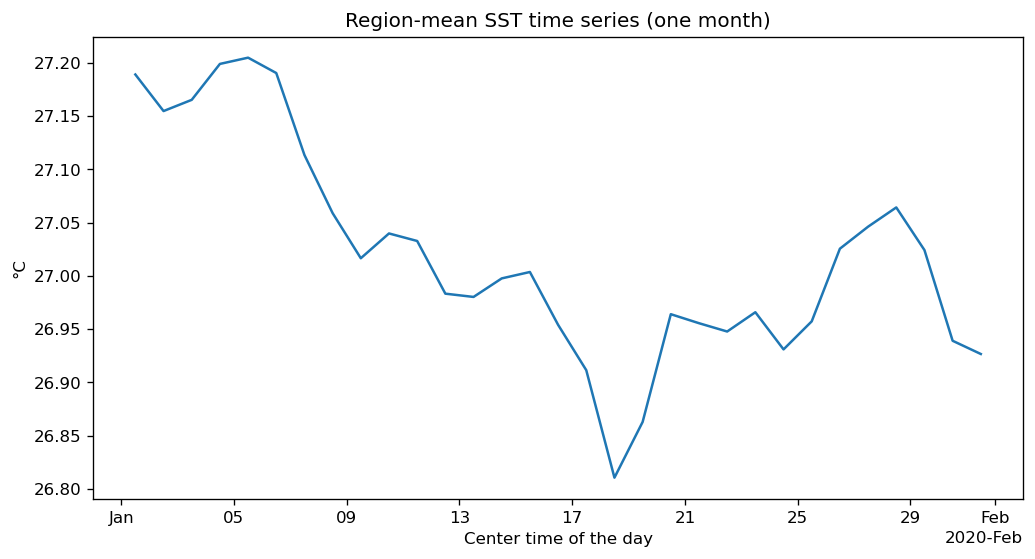

Warmest day: 2020-01-05 27.2
Coolest day: 2020-01-18 26.81


/var/folders/jc/711xkp256bz0pq8mq4dcp94h0000gn/T/ipykernel_48529/872131786.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Warmest day:', pd.to_datetime(ts.time[imax].values).date(), round(float(ts.isel(time=imax).values),2))
/var/folders/jc/711xkp256bz0pq8mq4dcp94h0000gn/T/ipykernel_48529/872131786.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Coolest day:', pd.to_datetime(ts.time[imin].values).date(), round(float(ts.isel(time=imin).values),2))


In [14]:
ts = dss[var].mean(dim=['lat','lon'])

ts_mean = ts.mean().compute()
ts_std  = ts.std().compute()
print('Month mean SST (°C):', round(float(ts_mean.values),2))
print('Month std SST (°C):', round(float(ts_std.values),3))

ts.load().plot()
plt.title('Region-mean SST time series (one month)')
plt.ylabel('°C')
plt.show()

imax = int(ts.argmax('time'))
imin = int(ts.argmin('time'))
print('Warmest day:', pd.to_datetime(ts.time[imax].values).date(), round(float(ts.isel(time=imax).values),2))
print('Coolest day:', pd.to_datetime(ts.time[imin].values).date(), round(float(ts.isel(time=imin).values),2))


Max anomaly (°C): 0.18
Min anomaly (°C): -0.21


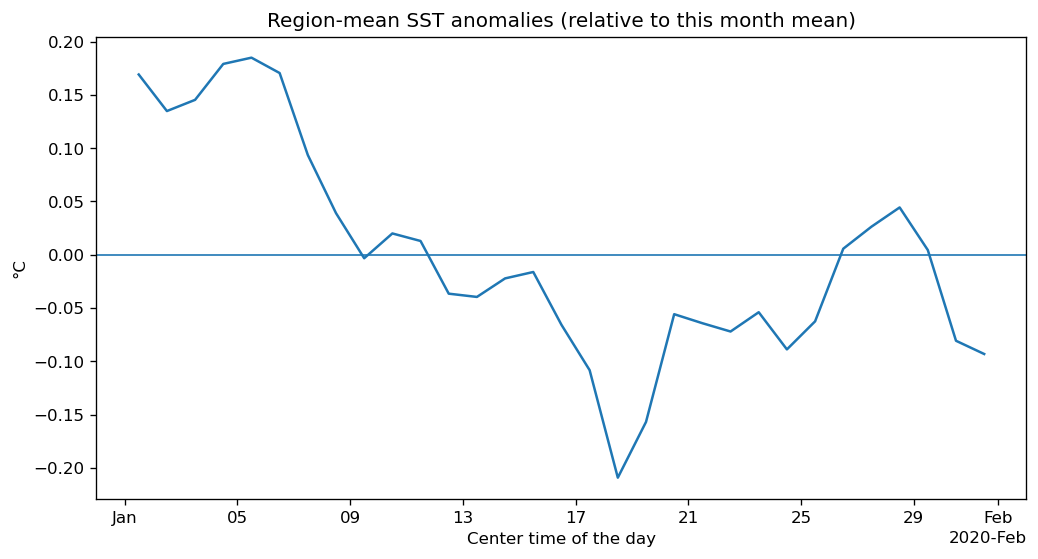

In [16]:
month_mean = dss[var].mean('time')
anom = dss[var] - month_mean

ts_anom = anom.mean(dim=['lat','lon'])
print('Max anomaly (°C):', round(float(ts_anom.max().compute().values),2))
print('Min anomaly (°C):', round(float(ts_anom.min().compute().values),2))

ts_anom.load().plot()
plt.title('Region-mean SST anomalies (relative to this month mean)')
plt.axhline(0, lw=1)
plt.ylabel('°C')
plt.show()


## 5) Regional maps: month-mean and variability

Make maps of month-mean SST and within-month variability (std and range).

**🧩 Questions**
1. What patterns do you notice?
2. Where is variability strongest?

**Answers**
1. SSTs are warmest to the west and to the north and south of the equator, with coolest temps along the equator and toward the eastern edge of the Nino3.4 bounding box
2. Strongest variability, as indicated by both standard deviation and range, is found in the northeastern portion of the bounding box


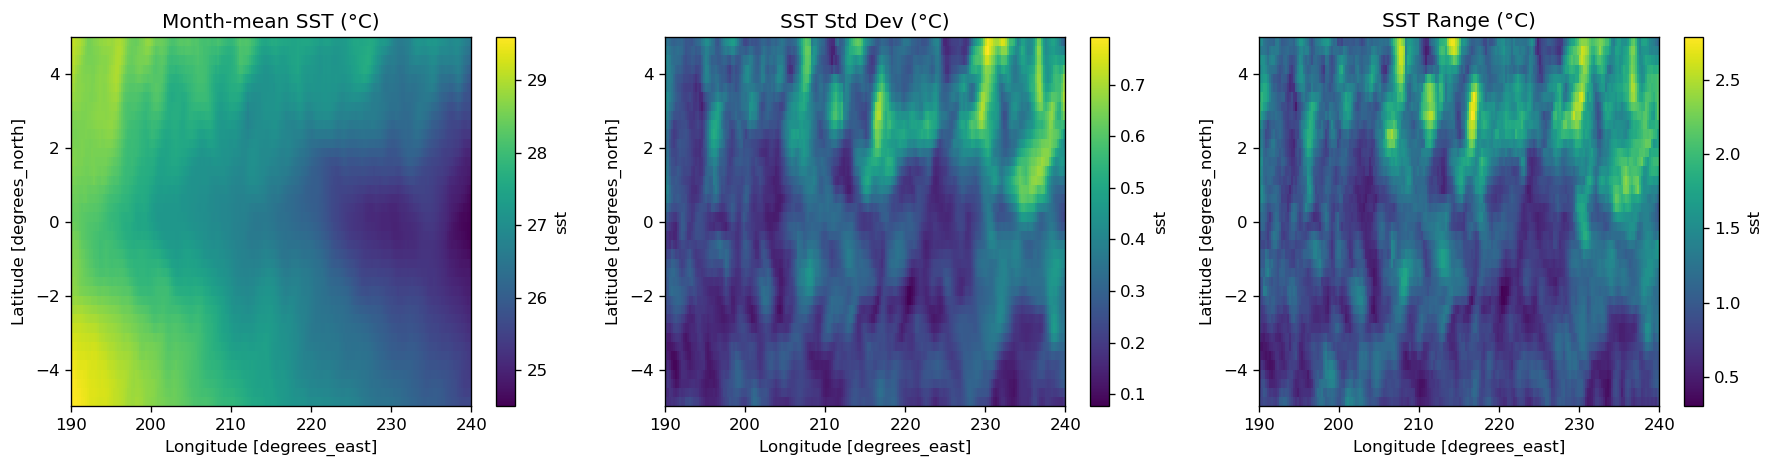

In [22]:
mean_sst = dss[var].mean('time')
std_sst  = dss[var].std('time')
range_sst = dss[var].max('time') - dss[var].min('time')

fig = plt.figure(figsize=(15,4))
ax = plt.subplot(1,3,1); mean_sst.plot(ax=ax); ax.set_title('Month-mean SST (°C)')
ax = plt.subplot(1,3,2); std_sst.plot(ax=ax); ax.set_title('SST Std Dev (°C)')
ax = plt.subplot(1,3,3); range_sst.plot(ax=ax); ax.set_title('SST Range (°C)')
plt.tight_layout() 
plt.savefig('Nino3-4_oisst_month_mean_std_range_202001.png', dpi=150, pad_inches=0.2)
plt.show()



## 6) Export a small subset for sharing (Check In Problem for Module 2)

Write a NetCDF with your regional mean time series and month-mean/variability maps.  Upload with your committed repository.

In [ ]:
# regional mean time series: ts = dss[var].mean(dim=['lat','lon'])
# month-mean and std and range maps



In [19]:
ts.to_netcdf("Nino3-4_oisst_region_mean_timeseries_202001.nc")